In [63]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon

In [64]:
# Define a general dataframe to hold all data
all_data = pd.DataFrame()

for i in range(1, 10):
    # Create a directory for each run
    data_file_path = f'run{i}/data.csv'

    # Read the CSV file into a pandas dataframe
    df = pd.read_csv(data_file_path)

    # Add a new column 'run' with the value of i
    df['run'] = i

    # Append the dataframe to the all_data dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)

print (all_data.head())

         asm  n_macro  n_conditional  n_update   approach  exec_time  \
0  Ascensore        1              6         7  evoavalla      78856   
1  Ascensore        1              6         7     random         29   
2  Ascensore        1              6         7       atgt        816   
3     ATM3v2       10             21        17  evoavalla      84221   
4     ATM3v2       10             21        17     random         95   

   n_scenarios  n_step  n_set  n_check  macro_coverage  branch_coverage  \
0            2       6      3       16             1.0         0.833333   
1            2       6      4       11             1.0         0.583333   
2            7      11     11       17             1.0         0.833333   
3            0       0      0        0             0.0         0.000000   
4            5      25     24       79             0.6         0.285714   

   update_rule_coverage  n_failing_scenarios  run  
0              1.000000                    0    1  
1           

Approach: evoavalla, Mean Execution Time: 80017.69, Std Dev: 11223.95
Approach: random, Mean Execution Time: 46.30, Std Dev: 108.74
Approach: atgt, Mean Execution Time: 1108.94, Std Dev: 954.19


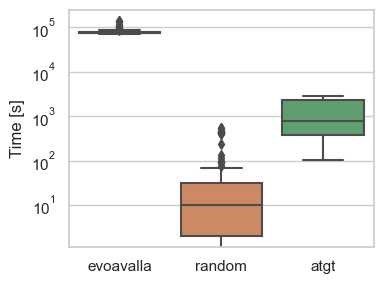

In [77]:
# For each approach, calculate the mean and standard deviation of the 'exec_time' column    
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_exec_time = approach_data['exec_time'].mean()
    std_exec_time = approach_data['exec_time'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Execution Time: {mean_exec_time:.2f}, Std Dev: {std_exec_time:.2f}")

# Generate a boxplot for the execution times of each approach
# Set the style of seaborn
sns.set(style="whitegrid")
# Create a boxplot
plt.figure(figsize=(4, 3))
sns.boxplot(x='approach', y='exec_time', data=all_data)
# set log scale for y-axis
plt.yscale('log')
plt.xlabel('')
plt.ylabel('Time [s]')
plt.tight_layout()

# Save the image as pdf
plt.savefig('images/boxplot_exec_time.pdf', bbox_inches='tight')

In [66]:
# For each approach, calculate the mean and standard deviation of the 'branch_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_branch_coverage = approach_data['branch_coverage'].mean()
    std_branch_coverage = approach_data['branch_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Branch Coverage: {mean_branch_coverage:.2f}, Std Dev: {std_branch_coverage:.2f}")

Approach: evoavalla, Mean Branch Coverage: 0.56, Std Dev: 0.31
Approach: random, Mean Branch Coverage: 0.45, Std Dev: 0.26
Approach: atgt, Mean Branch Coverage: 0.84, Std Dev: 0.33


In [67]:
# For each approach, calculate the mean and standard deviation of the 'macro_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_macro_coverage = approach_data['macro_coverage'].mean()
    std_macro_coverage = approach_data['macro_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Macro Coverage: {mean_macro_coverage:.2f}, Std Dev: {std_macro_coverage:.2f}")

Approach: evoavalla, Mean Macro Coverage: 0.80, Std Dev: 0.33
Approach: random, Mean Macro Coverage: 0.65, Std Dev: 0.39
Approach: atgt, Mean Macro Coverage: 0.88, Std Dev: 0.33


In [68]:
# For each approach, calculate the mean and standard deviation of the 'update_rule_coverage' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_update_rule_coverage = approach_data['update_rule_coverage'].mean()
    std_update_rule_coverage = approach_data['update_rule_coverage'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Update Rule Coverage: {mean_update_rule_coverage:.2f}, Std Dev: {std_update_rule_coverage:.2f}")

Approach: evoavalla, Mean Update Rule Coverage: 0.57, Std Dev: 0.37
Approach: random, Mean Update Rule Coverage: 0.36, Std Dev: 0.31
Approach: atgt, Mean Update Rule Coverage: 0.86, Std Dev: 0.33


In [69]:
# For each approach, calculate the mean and standard deviation of the 'n_scenarios' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_scenarios = approach_data['n_scenarios'].mean()
    std_n_scenarios = approach_data['n_scenarios'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Scenarios: {mean_n_scenarios:.2f}, Std Dev: {std_n_scenarios:.2f}")

Approach: evoavalla, Mean Number of Scenarios: 3.73, Std Dev: 5.59
Approach: random, Mean Number of Scenarios: 4.13, Std Dev: 4.84
Approach: atgt, Mean Number of Scenarios: 11.38, Std Dev: 10.45


In [70]:
# For each approach, calculate the mean and standard deviation of the 'n_step' column
for approach in all_data['approach'].unique():
    # Filter the dataframe for the current approach
    approach_data = all_data[all_data['approach'] == approach]

    # Calculate mean and standard deviation
    mean_n_step = approach_data['n_step'].mean()
    std_n_step = approach_data['n_step'].std()

    # Print the results
    print(f"Approach: {approach}, Mean Number of Steps: {mean_n_step:.2f}, Std Dev: {std_n_step:.2f}")

Approach: evoavalla, Mean Number of Steps: 9.04, Std Dev: 13.83
Approach: random, Mean Number of Steps: 14.52, Std Dev: 14.24
Approach: atgt, Mean Number of Steps: 168.75, Std Dev: 318.89
